## 6. Fitting and minimizing the data image by applying the star-by-star approach 


In Notebook 2, the data image with PSF was generated. In Notebook 5, the FOV is divided into sub-grids and the star-by-star or the 'nearest negihbour approach' is applied, where only the stars within the dispersive range of the concerned stars spectrum are considered in the analysis. A template 

The notebook is divided into the following sections:
1. Defining Input Parameters
2. Fitting regions for a given number of stars

Script written by: **Soumya Shreeram** <br/> 
Project supervised by: **Nadine Neumayer and Francisco Nogueras-Lara (MPIA)** <br/>
Date: **30th November 2020** <br/>

In [1]:
import astropy.units as u
import astropy.io.fits as fits

import math
from scipy.sparse import csr_matrix
import scipy.stats as stats
import numpy as np
import os
import importlib

# generate random integer values
from random import seed
from random import randint

# plotting imports
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib import cm
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

# to show progress during computations
from time import sleep
import sys

import matplotlib
import seaborn as sns

# for doing combinatorics with spectra
from itertools import permutations
from more_itertools import distinct_permutations

In [2]:
%matplotlib inline
font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import Simulating_Spectra as ss
import plotting as pt
import Slitless_spec_forward_modelling as ssfm
import star_by_star_template_library as stl
import Fitting_and_pdfs as fap

#### 01. Defining Input Parameters

In [4]:
# FOV in pixels
l_pix, u_pix = 0, 1128

# loads the effective FoV
x_pos, y_pos, mag_H, mag_Ks = np.load('Data/selected_FOV.npy')
selected_c_pxls = np.load('Data/selected_central_pixels.npy')

# directory paths
template_dir = 'Data/Template_library/'
save_data_crop_dir = 'Data/Cropped_Data_Images/'
save_data_psf_crop_dir = 'Data/Cropped_Data_PSF_Images/'
        
# set the dispersion range of the spectra
disperse_range = ss.defineDispersionRange(r=4000, lambda0=2.2, band_width=0.4)
print('The size of dispersion is set to be %d pixels'%disperse_range)

# effective FoV dimensions
u_pix_arr = [int(u_pix+disperse_range), u_pix]

dispersion_angle = 0 # degrees

# width of influence of the PSF on neighbouring stars (pixels)
width=3

# number to which the dimensions of the original image is reduced to cal chi-squared
num_splits = 5

# different populations of hot stars considered 
hot_stars_arr = np.arange(0, 11)/10

# would you like to discard foreground stars completely or do something more complicated
discard_forground_stars = False
foreground_cutoff = 1.1

# discards background stars from the effective FoV
if discard_forground_stars:
    x_pos, y_pos, mag_H, mag_Ks = ssfm.discardForegroundStars(x_pos, y_pos, mag_H, mag_Ks, foreground_cutoff)
    num_stars = len(mag_Ks)

# start pixels of a small region of the sky
x_start, y_start = 0, 0

# start pixels in the original file
x_start_og, y_start_og = 1000, 2500

The size of dispersion is set to be 727 pixels


#### 2. Extracting information on the neighbouring population of stars for the concerned FOV

In [5]:
# these arrays that hold information about the location and number of neighbours
star_neighbours, num_neighbours, x_FOV, y_FOV = stl.findStarAndNeighbours(x_pos, y_pos, mag_H,\
                                                            mag_Ks, disperse_range,\
                                                            width, selected_c_pxls,\
                                                           [x_start, y_start], u_pix)

# arrays extract information about the no. of neighbours in total & outside FOV
neighbours_outside_FOV = np.array(num_neighbours[1])-np.array(num_neighbours[0])
total_neighbours = np.array(num_neighbours[1])

Around 9180 stars form neighbours, of which most are repeats. In total, 98715 stars need to be modelled.


#### 3. Fitting regions with n-stars

In [167]:
importlib.reload(ssfm)
importlib.reload(fap)
# model all regions with x neighbouring stars
n_stars = 11

resulting_params_all = [] 

# define the limits of the region to be cropped
limits = np.load(save_data_crop_dir + '%d_stars/limits.npy'%(n_stars))

# associate spectra to those stars
stars_with_n_neighbours = np.where(total_neighbours == n_stars)


for i, stars_idx in enumerate(stars_with_n_neighbours[0][0:3]):
    # arr to save the chi-sq val for a given hot star distribution, and the best template no. for this chi-sq
    save_all_chi_sqs, perms_lens = [], [] 
    resulting_params = np.zeros((0, 2))
    
    print('\nRegion %d of %d:'%(i, len(stars_with_n_neighbours[0])))
    
    # get positions and magnitudes of the neighbouring stars
    x, y, mKs = star_neighbours[1][stars_idx][0], star_neighbours[1][stars_idx][1], star_neighbours[1][stars_idx][3]
    
    data_mat_arr = fap.loadDataReduceResolution(n_stars, i, num_splits, limits, save_data_crop_dir, save_data_psf_crop_dir)
    # iterating over every possible hot star population
    for j, hot_stars in enumerate(hot_stars_arr): 
        print('%d percent hot stars -- '%(hot_stars*100))
        
        # generate 2D matricies from the template library by associating x, y and mKs to spectra
        perms = np.load(template_dir+'%d_stars/%d_hot_stars/perm_arr.npy'%(n_stars, hot_stars*n_stars)) 
        
        # iterating over all the permutations for the given hot star population
        chi_sq_vals, min_chi_sq,  best_fit_perm_no = fap.generateTemplatesCalChiSquare(x, y, mKs, template_dir, save_data_psf_crop_dir, n_stars,\
                                                      hot_stars, perms, disperse_range, dispersion_angle,\
                                                      u_pix_arr, limits[i], data_mat_arr, i, x_FOV[stars_idx],\
                                                                         num_splits=5)
        
        save_all_chi_sqs.append(chi_sq_vals)
        resulting_params = np.append(resulting_params, [[min_chi_sq, best_fit_perm_no]], axis=0)
    
    # save the results of the computation for every region
    resulting_params_all.append(save_all_chi_sqs) 
    
# save the best chi-square values for the given region
np.save('Data/Chi_sq_vals/%d_stars_%d_regions.npy'%(n_stars, len(stars_with_n_neighbours[0])), resulting_params_all)


Region 0 of 255:
0 percent hot stars -- 
10 percent hot stars -- 
20 percent hot stars -- 
30 percent hot stars -- 
40 percent hot stars -- 
50 percent hot stars -- 
60 percent hot stars -- 
70 percent hot stars -- 
80 percent hot stars -- 
90 percent hot stars -- 
100 percent hot stars -- 

Region 1 of 255:
0 percent hot stars -- 
10 percent hot stars -- 
20 percent hot stars -- 
30 percent hot stars -- 
40 percent hot stars -- 
50 percent hot stars -- 
60 percent hot stars -- 
70 percent hot stars -- 
80 percent hot stars -- 
90 percent hot stars -- 
100 percent hot stars -- 

Region 2 of 255:
0 percent hot stars -- 
10 percent hot stars -- 
20 percent hot stars -- 
30 percent hot stars -- 
40 percent hot stars -- 
50 percent hot stars -- 
60 percent hot stars -- 
70 percent hot stars -- 
80 percent hot stars -- 
90 percent hot stars -- 
100 percent hot stars -- 


/home/shreeram/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


As we find all the best fitting templates, another important piece of info is to extract the stellar types of the stars for the regions in the defined 'data' image.

In [180]:
importlib.reload(stl)
stellar_types_data_arr, target_star_type, target_star_idx = stl.findStellarTypesDataStars(n_stars, hot_stars_arr, stars_with_n_neighbours, star_neighbours, x_pos, y_pos, x_FOV, y_FOV)
print('There are %d hot target stars among the %d regions with %d stars i.e. %.2f percent'%(stl.countHotStars(target_star_type), len(target_star_type), n_stars, stl.countHotStars(target_star_type)/len(target_star_type)))

There are 23 hot target stars among the 255 regions with 11 stars i.e. 0.09 percent


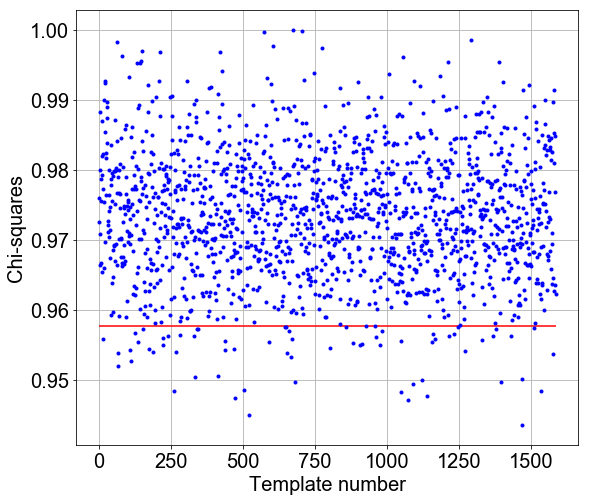

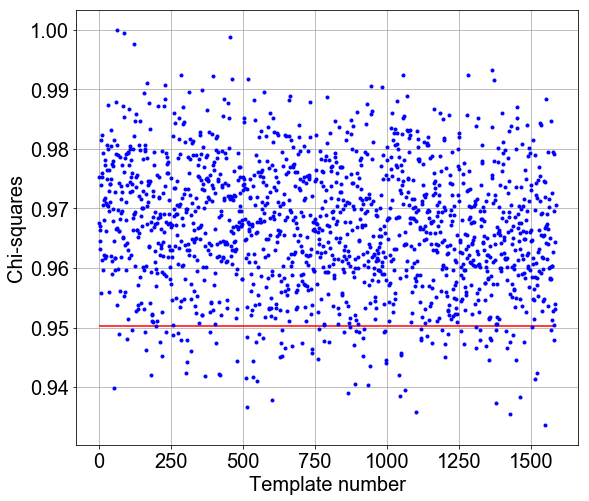

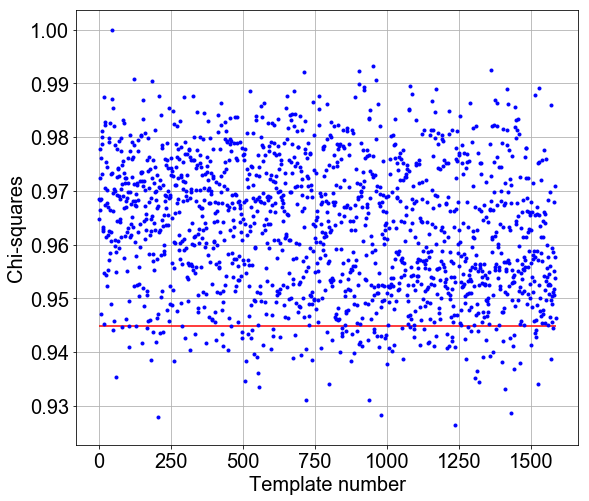

In [181]:
importlib.reload(fap)
for i, stars_idx in enumerate(stars_with_n_neighbours[0][0:3]):
    # 
    norm_chi_sqs, selected_temps = fap.analyzeAllChiSqs(resulting_params_all, i, plot_fig=True)

In [187]:
importlib.reload(stl)
target_star_prediction_all = []
for i, stars_idx in enumerate(stars_with_n_neighbours[0][0:3]):
    
    best_fit_perm_all = stl.findTemplateNumber(template_dir, selected_temps, resulting_params_all, hot_stars_arr, n_stars, region_idx=i)
    
    target_star_prediction = []
    for idx in range(len(best_fit_perm_all)):
        target_star_prediction.append(best_fit_perm_all[idx][target_star_idx[i]])
        target_star_prediction_all.append(target_star_prediction)

In [194]:
np.shape(resulting_params_all[0][1])

(11,)

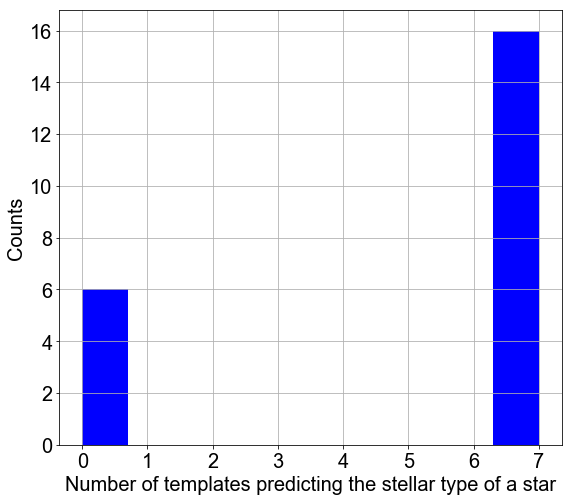

In [190]:
fig, ax = plt.subplots(1,1,figsize=(9,8))

counts, _, _ = ax.hist(target_star_prediction_all[2], color='Blue')
pt.setLabel(ax, 'Number of templates predicting the stellar type of a star', 'Counts', '', 'default', 'default', legend=False)

Getting info about the data image stellar types

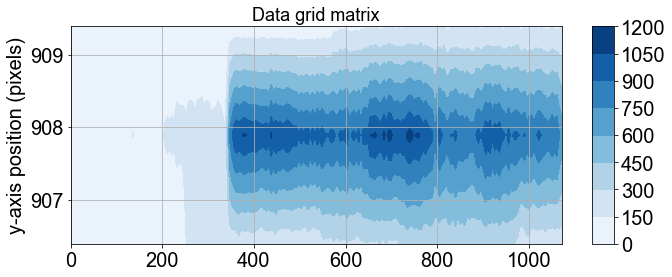

In [259]:
plotSubRegion(limits[-1], data_mat_arr[1], 'Data grid matrix', '', cmaps='Blues')